<a href="https://colab.research.google.com/github/b-fatma/S2I-DM/blob/master/src/preprocessing/elevation_no_binning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio
!pip install rioxarray

In [2]:
import rasterio as rio
import rioxarray as rxr
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

In [3]:
# import sys
# from pathlib import Path

# sys.path.append(str(Path.cwd().parent.parent))

# from config import raw_files, processed_files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# file_path = processed_files["elevation"] / "Elevation_DZ_TN.tif"
file_path = '/content/drive/MyDrive/dm_fire_prediction/processed/elevation/Elevation_DZ_TN.tif'
elevation_data = rxr.open_rasterio(file_path, masked=True).squeeze()

In [6]:
# Convert xarray to pandas DataFrame
elevation_df = elevation_data.to_dataframe(name='elevation').reset_index()


## Missing values

In [7]:
elevation_df.isna().sum()

,0
y,0
x,0
band,0
spatial_ref,0
elevation,9026840


<Axes: xlabel='x', ylabel='y'>

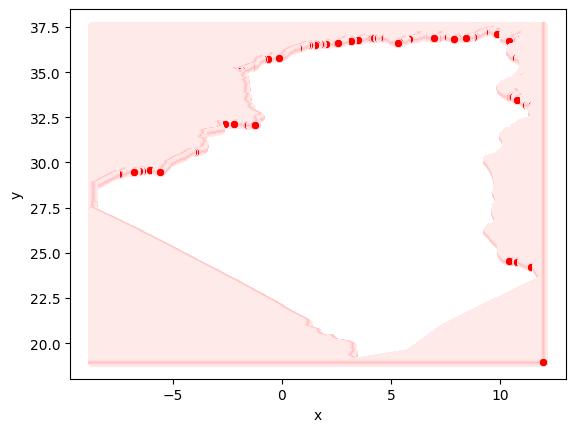

In [8]:
sns.scatterplot(data=elevation_df[elevation_df['elevation'].isna()], x='x', y='y', color='r')

The values are outside the borders, we can safely drop them

In [9]:
df = elevation_df[elevation_df['elevation'].notna()]

## Outliers

according to this https://en-gb.topographic-map.com/map-d8r1h/Algeria/?center=31.74685%2C7.74861&popup=34.25268%2C6.43404 resources, max elevation adn min elevation in dz are:

Average elevation: 511 m

Minimum elevation: -31 m

Maximum elevation: 3,622 m


In [10]:
df.describe()

,y,x,band,spatial_ref,elevation
count,1.311956e+07,1.311956e+07,13119560.0,13119560.0,1.311956e+07
mean,2.855396e+01,3.135884e+00,1.0,0.0,5.384417e+02
std,4.410324e+00,4.525084e+00,0.0,0.0,3.182768e+02
min,1.896028e+01,-8.673056e+00,1.0,0.0,-8.720000e+02
25%,2.508111e+01,-6.472222e-02,1.0,0.0,3.120000e+02
50%,2.838528e+01,3.510278e+00,1.0,0.0,4.640000e+02
75%,3.210194e+01,6.772778e+00,1.0,0.0,6.980000e+02
max,3.755611e+01,1.198528e+01,1.0,0.0,2.877000e+03


the -872 m instance is definitely an outlier, so we can remove it

In [11]:
df.drop(df[df['elevation'] <  -31].index, inplace=True)

/tmp/ipython-input-2056726543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['elevation'] <  -31].index, inplace=True)


In [12]:
elevation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22146400 entries, 0 to 22146399
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   y            float64
 1   x            float64
 2   band         int64  
 3   spatial_ref  int64  
 4   elevation    float32
dtypes: float32(1), float64(2), int64(2)
memory usage: 760.3 MB


<Axes: xlabel='elevation'>

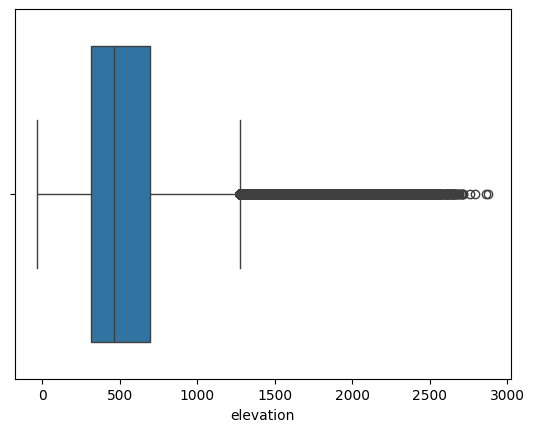

In [13]:
sns.boxplot(data=df, x='elevation')

<Axes: xlabel='elevation', ylabel='Count'>

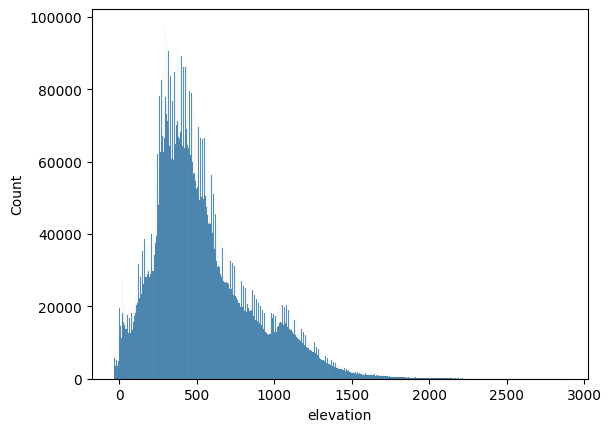

In [14]:
sns.histplot(data=df, x='elevation')

the data is pretty much right skewed, we can still check with a skewness measure

In [15]:
elevation_skew = stats.skew(df['elevation'])
print(f"Skewness: {elevation_skew}")

Skewness: 1.0560771226882935


removed spatial_ref and band (useless infos)

In [19]:
df = df[['x', 'y', 'elevation']]
df.head()

,x,y,elevation
9191,8.956111,37.556111,0.0
14149,8.947778,37.551944,0.0
29028,8.943611,37.539444,1.0
29029,8.947778,37.539444,0.0
33987,8.939444,37.535278,0.0


In [20]:
df = df.rename(columns={'x': 'longitude', 'y': 'latitude'})
df.head()

,longitude,latitude,elevation
9191,8.956111,37.556111,0.0
14149,8.947778,37.551944,0.0
29028,8.943611,37.539444,1.0
29029,8.947778,37.539444,0.0
33987,8.939444,37.535278,0.0


In [21]:
output_path = '/content/drive/MyDrive/dm_fire_prediction/premerge/elevation_no_binning.csv'

df.to_csv(output_path, index=False)